**Group Project**

## Getting the Data

https://www.kaggle.com/datasets/davidcariboo/player-scores

## Merging the Data

In [189]:
import pandas as pd
import numpy as np
import sklearn

In [190]:
#directory='C:/Users/Heidi Al Wakeel/Documents/GitHub/Football_Transfermarkt/Data/'
directory ="C:/Users/nguye/OneDrive/Documents/MMA/Winter 2023/Football_Transfermarkt/Data/"

In [191]:
# Reading CSV files into dataframes
appearances = pd.read_csv(directory+'appearances.csv')
club_games = pd.read_csv(directory+'club_games.csv')
clubs = pd.read_csv(directory+'clubs.csv')
competitions = pd.read_csv(directory+'competitions.csv')
game_events = pd.read_csv(directory+'game_events.csv')
games = pd.read_csv(directory+'games.csv')
player_valuations = pd.read_csv(directory+'player_valuations.csv')
players = pd.read_csv(directory+'players.csv')

In [192]:
# Yearly Player Game Stats
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['year'] = appearances['date'].dt.year
player_games_stats = appearances.\
    groupby(['player_id', 'year']).\
    agg(avg_game_dur = ('minutes_played', 'mean'),
        avg_games_played = ('appearance_id', 'count'),
        avg_yellow_cards = ('yellow_cards', 'mean'),
        avg_red_cards = ('red_cards', 'mean'),
        avg_goals = ('goals', 'mean'),
        avg_assists = ('assists', 'mean'),
        avg_minutes_played = ('minutes_played', 'mean')).\
    reset_index()
player_games_stats.head(1)

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played
0,10,2014.0,33.066667,15,0.133333,0.0,0.266667,0.2,33.066667


In [193]:
# Yearly Player Games Played (away & home)
player_games_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(games_played = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='games_played').\
    reset_index().\
    rename(columns={'Away': 'games_played_away', 'Home': 'games_played_home'})
player_games_home_away.head(1)

hosting,player_id,year,games_played_away,games_played_home
0,10,2014.0,7.0,8.0


In [194]:
# Yearly Player Win Percentage (away & home)
player_win_perc_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='win_perc').\
    reset_index().\
    rename(columns={'Away': 'away_win_percentage', 'Home': 'home_win_percentage'})
player_win_perc_home_away.head(1)

hosting,player_id,year,away_win_percentage,home_win_percentage
0,10,2014.0,0.285714,0.75


In [195]:
# Yearly Player Win Percentage (total)
player_win_perc = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index()
player_win_perc.head(1)

,player_id,year,win_perc
0,10,2014.0,0.533333


In [196]:
# Yearly Games Played by Competition Type
player_comp_types = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year', 'competition_type']).\
    agg(competitions_attended = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='competition_type', values='competitions_attended').\
    reset_index().\
    fillna({'domestic_cup':0, 'domestic_league':0, 'international_cup':0, 'other':0}).\
    rename(columns={'domestic_cup': 'games_player_domestic_cup', 'domestic_league': 'games_played_domestic_league',
            'international_cup': 'games_player_international_cup', 'other': 'games_played_other'})
player_comp_types.head(1)

competition_type,player_id,year,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other
0,10,2014.0,1.0,14.0,0.0,0.0


In [197]:
# Player Popularity
player_pop = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year']).\
    agg(player_avg_game_attendance = ('attendance', 'mean')).\
    reset_index()
player_pop.head(1)

,player_id,year,player_avg_game_attendance
0,10,2014.0,25929.266667


In [198]:
# Player Stats
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['year_of_birth'] = players['date_of_birth'].dt.year
player_relevant_stats = players[['player_id', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm', 'year_of_birth']]
player_relevant_stats.head(1)

,player_id,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth
0,134354,Belgium,Belgium,Aalst,Attack,Centre-Forward,Right,0,1995.0


In [199]:
# Player Valuation (Mnay NA Values because it is tracked much earlier than stats)
player_valuations['date'] = pd.to_datetime(player_valuations['date'])
player_valuations['year'] = player_valuations['date'].dt.year
player_yearly_val =player_valuations.\
    groupby(['player_id', 'year']).\
    agg(mean_market_value_in_eur = ('market_value_in_eur', 'mean'),
        max_market_value_in_eur = ('market_value_in_eur', 'max')).\
    reset_index()

In [200]:
# Final Aggregation
data = player_games_stats.\
    merge(player_games_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc, on=['player_id', 'year'], how='outer').\
    merge(player_comp_types, on=['player_id', 'year'], how='outer').\
    merge(player_pop, on=['player_id', 'year'], how='outer').\
    merge(player_yearly_val, on=['player_id', 'year'], how='outer').\
    merge(player_relevant_stats, on=['player_id'], how='left')
data['age'] = data['year'] - data['year_of_birth']
data.columns

Index(['player_id', 'year', 'avg_game_dur', 'avg_games_played',
       'avg_yellow_cards', 'avg_red_cards', 'avg_goals', 'avg_assists',
       'avg_minutes_played', 'games_played_away', 'games_played_home',
       'away_win_percentage', 'home_win_percentage', 'win_perc',
       'games_player_domestic_cup', 'games_played_domestic_league',
       'games_player_international_cup', 'games_played_other',
       'player_avg_game_attendance', 'mean_market_value_in_eur',
       'max_market_value_in_eur', 'country_of_citizenship', 'country_of_birth',
       'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm',
       'year_of_birth', 'age'],
      dtype='object')

In [201]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,max_market_value_in_eur,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth,age
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,36.0
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,37.0
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,38.0
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,5000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,34.0
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,3000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,35.0


## Feature Engineering

In [202]:
from countryinfo import countries

In [203]:
country=[]
continent=[]
for i in countries :
    country.append(i['name'])
    continent.append(i['continent'])

In [204]:
mapping=pd.DataFrame({'country_of_citizenship':country,'continent':continent})

In [205]:
data=data.merge(mapping, on='country_of_citizenship', how='left')

In [206]:
data.drop(columns=['country_of_citizenship','country_of_birth','city_of_birth'],inplace=True)

In [207]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,25929.266667,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,36.0,Europe
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,28502.472222,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,37.0,Europe
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,19311.600000,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,38.0,Europe
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,57578.411765,5000000.0,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,55057.333333,2000000.0,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe


In [208]:
# For Imputation (Filling some null values with 0)
data = data.query('avg_games_played > 0')
#data = data.dropna(subset=['win_perc', 'mean_market_value_in_eur'])
data = data.fillna({'games_played_away': 0, 
                    'games_played_home': 0, 
                    'games_player_domestic_cup': 0, 
                    'games_played_domestic_league': 0, 
                    'games_player_international_cup': 0, 
                    'games_played_other': 0,
                    'away_win_percentage' : 0,
                    'home_win_percentage' : 0})

for col in data.columns:
    null_rows_idx = data[[col]].isnull().any(axis=1)
    if len(data[null_rows_idx]) > 0:
        print(col, data[null_rows_idx].shape)
# Output shows us which columns still have null values which we will fix/impute later in Data Cleaning

data.to_csv('data_merged.csv')

win_perc (122, 28)
mean_market_value_in_eur (2167, 28)
max_market_value_in_eur (2167, 28)
position (32, 28)
sub_position (5596, 28)
foot (1281, 28)
height_in_cm (32, 28)
year_of_birth (53, 28)
age (53, 28)
continent (11174, 28)


In [209]:
data.year_of_birth=data.year_of_birth.astype('str')

In [210]:
data['contribution_per_game']=data['avg_goals']+data['avg_assists']

## Analyzing the Data Structure

In [211]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent,contribution_per_game
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,36.0,Europe,0.466667
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,37.0,Europe,0.555556
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,38.0,Europe,0.650000
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,5000000.0,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe,0.000000
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,2000000.0,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe,0.000000


In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64924 entries, 0 to 64923
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       64924 non-null  int64  
 1   year                            64924 non-null  float64
 2   avg_game_dur                    64924 non-null  float64
 3   avg_games_played                64924 non-null  float64
 4   avg_yellow_cards                64924 non-null  float64
 5   avg_red_cards                   64924 non-null  float64
 6   avg_goals                       64924 non-null  float64
 7   avg_assists                     64924 non-null  float64
 8   avg_minutes_played              64924 non-null  float64
 9   games_played_away               64924 non-null  float64
 10  games_played_home               64924 non-null  float64
 11  away_win_percentage             64924 non-null  float64
 12  home_win_percentage             

In [213]:
data.describe()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,height_in_cm,age,contribution_per_game
count,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,...,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,6.275700e+04,6.275700e+04,64892.000000,64871.000000,64924.000000
mean,201168.041957,2017.933692,63.651873,15.982965,0.140592,0.003807,0.074128,0.056940,63.651873,8.023335,...,1.046916,13.723415,1.166656,0.045977,14400.010437,3.874549e+06,4.394323e+06,180.097793,25.905227,0.131068
std,161988.736461,2.465908,24.158194,11.637990,0.155056,0.025462,0.131111,0.095831,24.158194,5.932188,...,1.378357,10.001174,2.546848,0.254883,12958.278553,8.994894e+06,9.949812e+06,20.483944,4.535568,0.182305
min,10.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+04,1.000000e+04,0.000000,15.000000,0.000000
25%,64992.000000,2016.000000,48.102586,6.000000,0.000000,0.000000,0.000000,0.000000,48.102586,3.000000,...,0.000000,5.000000,0.000000,0.000000,4345.424242,4.000000e+05,4.500000e+05,177.000000,22.000000,0.000000
50%,164912.500000,2018.000000,69.882353,14.000000,0.111111,0.000000,0.000000,0.000000,69.882353,7.000000,...,1.000000,13.000000,0.000000,0.000000,10650.525000,1.000000e+06,1.000000e+06,182.000000,26.000000,0.066667
75%,292357.000000,2020.000000,84.111111,24.000000,0.214286,0.000000,0.103448,0.090909,84.111111,12.000000,...,2.000000,20.000000,0.000000,0.000000,20633.825000,3.166667e+06,3.600000e+06,187.000000,29.000000,0.200000
max,987700.000000,2022.000000,120.000000,59.000000,2.000000,1.000000,3.000000,2.000000,120.000000,31.000000,...,11.000000,44.000000,19.000000,5.000000,83439.000000,2.000000e+08,2.000000e+08,206.000000,44.000000,3.000000


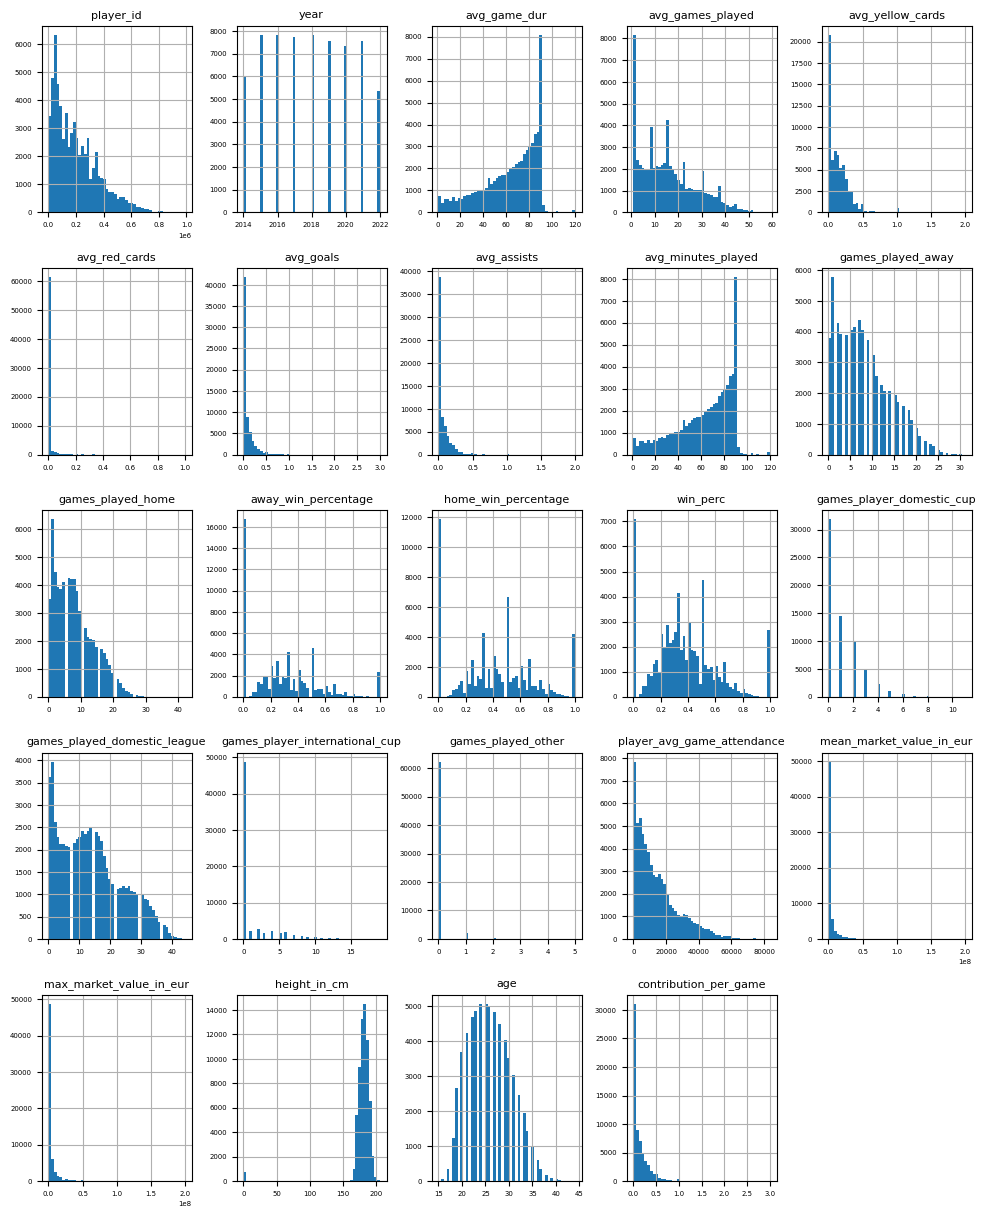

In [214]:
import matplotlib.pyplot as plt

plt.rc('font', size = 5)
plt.rc('axes', labelsize = 5, titlesize = 8)
plt.rc('legend', fontsize = 5)
plt.rc('xtick', labelsize = 5)
plt.rc('ytick', labelsize = 5)

data.hist(bins = 50, figsize = (12, 15))
plt.show()

Many variables are skewed to the left/right, meaning that they extend on the left/right of the median. This can make it difficult for our model to identify patterns. Later, we will transform these attributes to have normal distributions.

# Preparing the Data for Machine Learning Algorithms

## Data Cleaning

In [215]:
null_rows_idx = data.isnull().any(axis=1)
data.loc[null_rows_idx].head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent,contribution_per_game
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.0,0.0,90.000000,10.0,...,5.000000e+06,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe,0.0
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.0,0.0,90.000000,11.0,...,2.000000e+06,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe,0.0
5,26,2016.0,92.000000,15.0,0.066667,0.0,0.0,0.0,92.000000,9.0,...,1.000000e+06,1000000.0,Goalkeeper,NaN,Left,190.0,1980.0,36.0,Europe,0.0
6,26,2017.0,60.333333,3.0,0.000000,0.0,0.0,0.0,60.333333,1.0,...,9.166667e+05,1000000.0,Goalkeeper,NaN,Left,190.0,1980.0,37.0,Europe,0.0
7,26,2018.0,1.000000,1.0,0.000000,0.0,0.0,0.0,1.000000,1.0,...,NaN,NaN,Goalkeeper,NaN,Left,190.0,1980.0,38.0,Europe,0.0


In [216]:
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 17932 rows with null values in the dataset.


## Advanced Imputation

In [217]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

num_cols = ['win_perc','age','height_in_cm','mean_market_value_in_eur','max_market_value_in_eur']
imputer = IterativeImputer()
imputed = imputer.fit_transform(data[num_cols])
data.loc[:, num_cols] = imputed

In [218]:
from sklearn.impute import SimpleImputer

# create an imputer that uses the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')

cat_cols=['continent','year_of_birth','foot','position']

# fit the imputer on the data frame
imputer.fit(data[cat_cols])

# transform the data frame
data[cat_cols] = imputer.transform(data[cat_cols])

In [219]:
# Filling in missing sub_position values

# Grouping sub_position by position
sub_positions_by_position = data.groupby('position')['sub_position'].apply(list)

# Finding the most frequent sub_position for each position
sub_positions_count_by_position = sub_positions_by_position.apply(lambda x: pd.Series(x).value_counts()).fillna(0).astype(int)
sub_positions_count_by_position_dict = sub_positions_count_by_position.to_dict()

# Finding the most frequent sub_position for each position
most_frequent_sub_positions_by_position = sub_positions_count_by_position.idxmax(axis=1)

# Creating a new DataFrame with position and most frequent sub_position columns
df = pd.DataFrame({'position': most_frequent_sub_positions_by_position.index,
                   'most_frequent_sub_position': most_frequent_sub_positions_by_position.values})

df

,position,most_frequent_sub_position
0,Attack,Centre-Forward
1,Defender,Centre-Back
2,Goalkeeper,Centre-Forward
3,Midfield,Central Midfield


In [220]:
df_merged = df.merge(sub_positions_count_by_position, left_on='position', right_index=True)
most_frequent_sub_positions_dict = df_merged.set_index('position')['most_frequent_sub_position'].to_dict()

# Replace sub_position null values with most frequent sub_positions for their corresponding positions
data['sub_position'] = data.apply(lambda row: most_frequent_sub_positions_dict[row['position']] if pd.isnull(row['sub_position']) else row['sub_position'], axis=1)

In [221]:
# Just to be sure that all worked, count the number of null values in the sub_position column
num_null_values = data['sub_position'].isnull().sum()

print(f"There are {num_null_values} null values in the sub_position column")

There are 0 null values in the sub_position column


In [222]:
# Just to make sure eveyrthing worked
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 0 rows with null values in the dataset.


## Handling Text and Categorical Attributes

In [223]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

## Entity Embedding

In [224]:
cat_cols=['continent','position','sub_position']

for i in cat_cols:  
    
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])

    # Define the number of categories and the embedding size
    num_categories = data[i].nunique()
    embedding_dim = data[i].nunique()//2

    # Create a tensor of categorical values
    categorical_column = torch.randint(low=0, high=num_categories, size=(len(data[i]),))

    # Create the embedding layer
    embedding_layer = nn.Embedding(num_embeddings=num_categories, embedding_dim=embedding_dim)

    # Apply the embedding layer to the categorical column
    embedded_column = embedding_layer(categorical_column)

    embedded_df = pd.DataFrame(embedded_column.detach().numpy(), columns=[i+f'_embed_{j}' for j in range(embedding_dim)])

    # Replace the original categorical column with the embedded DataFrame
    data = pd.concat([data.drop(i, axis=1), embedded_df], axis=1)

## One Hot Encoding

In [225]:
data.drop(columns='year_of_birth',inplace=True)
dummy_vars = pd.get_dummies(data['foot'],drop_first=True,prefix='foot')

data = pd.concat([data, dummy_vars], axis=1)
data.drop(columns='foot',inplace=True)

# Eliminate the ID columns

In [226]:
#data = data.drop(columns = "player_id")

## Data Leakage Analysis

Analyse how the performance changes between train, validation and test set - Rohana/Hai

Do post modelling

### Split data

In [227]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set,valid_set=split_train_test(data,0.3)
print("The length of train set is: ",len(train_set))
print("The length of valid set is: ",len(valid_set))



The length of train set is:  45447
The length of valid set is:  19477


In [228]:
valid_set,test_set=split_train_test(valid_set,0.4)
print("The length of valid set is: ",len(valid_set))
print("The length of test set is: ",len(test_set))
train_set.shape, test_set.shape

The length of valid set is:  11687
The length of test set is:  7790


((45447, 37), (7790, 37))

In [229]:
#Separate Features and Target
y_test = test_set['mean_market_value_in_eur']
X_test = test_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur'])


Separate Predictors and Target Variable


In [230]:
y_train = train_set['mean_market_value_in_eur']
X_train = train_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur']) ##taking anything related to market value to avoid data leakage
y_valid = valid_set['mean_market_value_in_eur']
X_valid= valid_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur']) ##t

Extract the player ID column

In [233]:
X_train_id = X_train["player_id"]
X_valid_id = X_valid["player_id"]
X_test_id = X_test['player_id']
X_train = X_train.drop(columns = "player_id")
X_test = X_test.drop(columns = "player_id")

KeyError: 'player_id'

In [234]:
X_valid = X_valid.drop(columns = "player_id")

Standardize Data

In [235]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)
#X_std = sc.fit_transform(X)
#X_std = pd.DataFrame(X_std,columns = X.columns)
X_valid_std = pd.DataFrame(X_valid_std,columns = X_valid.columns)
X_train_std = pd.DataFrame(X_train_std,columns = X_train.columns)
X_test_std = pd.DataFrame(X_test_std,columns = X_test.columns)


In [236]:
from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(random_state=0)
model = randomforest.fit(X_train_std,y_train)
model.feature_importances_
pd.DataFrame(list(zip(X_train.columns,model.feature_importances_)), columns=['predictor', 'feature importance']).sort_values("feature importance")


,predictor,feature importance
32,foot_Left,0.001348
33,foot_Right,0.002055
4,avg_red_cards,0.003127
23,continent_embed_2,0.003974
24,position_embed_0,0.003976
25,position_embed_1,0.004043
22,continent_embed_1,0.004346
21,continent_embed_0,0.005350
26,sub_position_embed_0,0.006041
16,games_played_other,0.006074


In [237]:
model_features = pd.DataFrame(list(zip(X_train_std.columns,model.feature_importances_)), columns = ['predictor','feature importance']).sort_values("feature importance")
model_features.tail(20)

,predictor,feature importance
29,sub_position_embed_3,0.007743
13,games_player_domestic_cup,0.008170
7,avg_minutes_played,0.012712
1,avg_game_dur,0.013197
3,avg_yellow_cards,0.014834
8,games_played_away,0.016810
14,games_played_domestic_league,0.016831
10,away_win_percentage,0.017629
6,avg_assists,0.017990
11,home_win_percentage,0.019639


## SHOULD DO Recursive Feature Elimination or so

In [238]:
from sklearn.feature_selection import RFE
rfe = RFE(randomforest, n_features_to_select = 20)
rfe.fit(X_train_std, y_train)
print(rfe.ranking_)

[ 1  1  1  1 13  1  1  1  1  1  1  1  1  3  1  1  9  1  1  1  1  8  5 11
 12 10  7  2  6  1  4  1 15 14]


In [239]:
# Define the feature names
feature_names = X_train_std.columns.tolist()
# Print the names of the important features
important_features = [i for i, x in enumerate(rfe.support_) if x]
selected_features = [feature_names[i] for i in important_features]
print("Important features:", selected_features)

Important features: ['year', 'avg_game_dur', 'avg_games_played', 'avg_yellow_cards', 'avg_goals', 'avg_assists', 'avg_minutes_played', 'games_played_away', 'games_played_home', 'away_win_percentage', 'home_win_percentage', 'win_perc', 'games_played_domestic_league', 'games_player_international_cup', 'player_avg_game_attendance', 'height_in_cm', 'age', 'contribution_per_game', 'sub_position_embed_3', 'sub_position_embed_5']


In [240]:
X_train_std = X_train_std[selected_features]
X_valid_std = X_valid_std[selected_features]
X_test_std = X_test_std[selected_features]

### PCA

In [241]:
from sklearn.decomposition import PCA

# Perform PCA on the training set
pca = PCA(n_components=X_train_std.shape[1])
X_train_pca = pca.fit_transform(X_train_std)

# Choose the number of components that explain at least 80% of the variance
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.8])
# Fit the PCA object with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_valid_pca = pca.transform(X_valid_std)

In [242]:
n_components

8

In [243]:
#from sklearn.decomposition import PCA
#scaler = StandardScaler()
#scaler.fit(train_set)
#scaled_data = scaler.transform(train_set)
#pca = PCA(n_components=2)
#pca.fit(scaled_data)
#x_pca = pca.transform(scaled_data)
#plt.figure(figsize=(8,6))
#plt.scatter(x_pca[:,0],x_pca[:,1],c=train_set['mean_market_value_in_eur'],cmap='tab20b')
#plt.xlabel('First principal component')
#plt.ylabel('Second Principal Component')

In [244]:
#import seaborn as sns
#map= pd.DataFrame(pca.components_,columns=train_set.columns)
#plt.figure(figsize=(12,6))
#sns.heatmap(map,cmap='twilight')

### Supervised Learning/ AutoML

In [245]:
# !pip install h2o
# --upgrade pip



In [246]:
import h2o
# from h2o.automl import H2OAutoML
# # initialize the h2o session
# h2o.init()
# load an h2o DataFrame from pandas DataFrame.

In [247]:
from h2o.automl import H2OAutoML

In [248]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 hours 21 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,"21 days, 11 hours and 51 minutes"
H2O_cluster_name:,H2O_from_python_nguye_hl3bqn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1020 Mb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [249]:
train_set.to_csv('automl_train.csv')
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45447 entries, 44531 to 8693
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       45447 non-null  int64  
 1   year                            45447 non-null  float64
 2   avg_game_dur                    45447 non-null  float64
 3   avg_games_played                45447 non-null  float64
 4   avg_yellow_cards                45447 non-null  float64
 5   avg_red_cards                   45447 non-null  float64
 6   avg_goals                       45447 non-null  float64
 7   avg_assists                     45447 non-null  float64
 8   avg_minutes_played              45447 non-null  float64
 9   games_played_away               45447 non-null  float64
 10  games_played_home               45447 non-null  float64
 11  away_win_percentage             45447 non-null  float64
 12  home_win_percentage          

In [250]:
df_test = h2o.import_file('automl_train.csv')

x = list(train_set.describe().columns)
x.remove('mean_market_value_in_eur')
x.remove('max_market_value_in_eur')
aml = H2OAutoML(max_models=10, seed=1)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [251]:
df_test

C1,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,games_played_home,away_win_percentage,home_win_percentage,win_perc,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,height_in_cm,age,contribution_per_game,continent_embed_0,continent_embed_1,continent_embed_2,position_embed_0,position_embed_1,sub_position_embed_0,sub_position_embed_1,sub_position_embed_2,sub_position_embed_3,sub_position_embed_4,sub_position_embed_5,foot_Left,foot_Right
44531,256819,2021,18.7,10,0.1,0,0.1,0,18.7,4,6,0.5,0.166667,0.3,2,8,0,0,1208.4,150000,150000,183,29,0.1,-0.226802,0.132047,1.93062,-1.69099,0.648527,0.776317,-0.814078,-1.83764,-0.612354,-1.30647,-0.144748,1,0
2901,16922,2016,41.96,25,0.24,0.04,0.24,0,41.96,11,14,0.363636,0.642857,0.52,3,22,0,0,27015.6,1.66667e+06,2e+06,186,29,0.24,-1.19609,-0.615401,1.57759,-0.476125,1.43916,0.476383,-0.718028,-1.61568,-1.56158,-0.200001,0.635975,0,1
57732,411975,2022,84.2273,22,0.0909091,0.0454545,0.136364,0,84.2273,12,10,0.166667,0.6,0.363636,2,16,4,0,28740,6e+07,6e+07,180,24,0.136364,1.44796,-1.55402,-0.605606,-0.476125,1.43916,0.219343,-0.158942,1.93015,-0.184802,0.234764,-0.538035,0,1
55782,380415,2018,73.85,20,0.05,0,0.3,0,73.85,10,10,0.3,0.6,0.45,0,15,5,0,28168.7,1e+07,1e+07,175,21,0.3,-1.19609,-0.615401,1.57759,-0.705654,0.887389,-1.33854,0.0196177,1.27327,-1.06523,-1.22095,0.0830908,0,1
13588,57372,2014,50.8125,16,0.0625,0,0,0,50.8125,9,7,0.444444,0.571429,0.5,0,16,0,0,24609.5,2.625e+06,3e+06,188,26,0,1.44796,-1.55402,-0.605606,0.0688344,-0.841474,-1.33854,0.0196177,1.27327,-1.06523,-1.22095,0.0830908,0,1
1843,12753,2018,82,2,0,0,0,0,82,1,1,0,1,0.5,0,2,0,0,10574.5,237500,250000,187,32,0,0.526337,1.11751,-1.07074,-1.69099,0.648527,0.776317,-0.814078,-1.83764,-0.612354,-1.30647,-0.144748,0,1
11508,50655,2021,74.7222,36,0.111111,0.0277778,0.111111,0.194444,74.7222,17,19,0.352941,0.473684,0.416667,0,36,0,0,1920.44,1.93333e+06,2e+06,169,32,0.305556,0.350149,2.45733,-2.09271,-0.476125,1.43916,2.1409,-0.0477984,2.36837,-0.356547,0.130243,1.17537,0,1
1068,7102,2015,33,1,0,0,0,0,33,1,0,1,0,1,0,1,0,0,13792,50000,50000,186,39,0,1.44796,-1.55402,-0.605606,-0.705654,0.887389,1.11922,-0.3324,-1.21834,-2.14885,1.56726,0.546789,0,1
47408,283489,2022,90,10,0,0,0,0,90,6,4,0.333333,0,0.2,3,7,0,0,16019.1,2e+06,2e+06,183,24,0,1.44796,-1.55402,-0.605606,-0.476125,1.43916,-0.52773,-0.637147,2.30953,1.34511,-0.96275,0.317904,0,1
17509,71835,2018,90,1,0,0,0,0,90,0,1,0,1,1,0,1,0,0,10813,800000,1e+06,184,29,0,1.44796,-1.55402,-0.605606,-0.476125,1.43916,1.11922,-0.3324,-1.21834,-2.14885,1.56726,0.546789,0,1


In [252]:
pred=aml.train(x=x, y='mean_market_value_in_eur', training_frame=df_test)
lb = aml.leaderboard # Leader board
print(lb.head(rows=lb.nrows)) # print leader board

AutoML progress: |█
23:43:57.862: AutoML: XGBoost is not available; skipping it.

███████████████ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_861ba0236ac76a19c30d8298a32f402b> was cancelled by the user.

In [ ]:
valid_set.to_csv('for_automl_test.csv')


In [ ]:
test = h2o.import_file('for_automl_test.csv')
preds = aml.predict(test)

In [ ]:
preds

In [ ]:
list_model=h2o.as_list(lb.head(rows=lb.nrows)['model_id'], use_pandas=False)
import itertools

list_m = list(itertools.chain(*list_model))
list_m


### Explainability of AutoML

In [ ]:
aml.explain(test)


## Model 

5.04685e+06

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train_pca, y_train)

pred1 = rf.predict(X_valid_pca)
rf_mse = mean_squared_error(y_valid, pred1)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

#### SVR

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train_pca, y_train)
pred2 = svm_reg.predict(X_valid_pca)


In [ ]:
svm_mse = mean_squared_error(y_valid, pred2)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

#### XGBoost

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train_pca, y_train)

pred3 = xg_reg.predict(X_valid_pca)
xgbt_rmse = np.sqrt(mean_squared_error(y_valid, pred3))
xgbt_rmse


#### Gradient Boosting Tree



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


gbt = GradientBoostingRegressor(random_state=0)
model2 = gbt.fit(X_train_pca,y_train)
pred4 = model2.predict(X_valid_pca)
gbt_rmse = np.sqrt(mean_squared_error(y_valid, pred4))
gbt_rmse

#### LGBM

In [253]:
from lightgbm import LGBMRegressor
# fit the model on the whole dataset
lgbm_reg_model = LGBMRegressor()
lgbm_reg_model.fit(X_train_pca, y_train)

#Testing
pred5 = lgbm_reg_model.predict(X_valid_pca)
lgbm_reg_mse = mean_squared_error(y_valid, pred5)
lgbm_reg_rmse = np.sqrt(lgbm_reg_mse)
lgbm_reg_rmse

2023/04/25 23:48:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '031f9449989441cd9b125e5c7283c55e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
2023/04/25 23:48:36 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3

6645028.354874397

In [ ]:
X_valid_pca

#Index the array with the player ID
#Save it to the pickle file
# Pickle the actual model

In [ ]:
import seaborn as sns
df = {'Models': ["Random Forest Regressor","Gradient Boosting Regressor", 'XG Boost','LightGBM','SVR'],
     'RMSE': [rf_rmse,gbt_rmse,xgbt_rmse,lgbm_reg_rmse,svm_rmse]
     }

summary = pd.DataFrame(df)
plt.figure(figsize=(8, 6))
splot=sns.barplot(x="RMSE",y="Models",data=summary)
plt.xlabel("RMSE", size=14)
plt.ylabel("Models", size=14)

## Hyper Parameter Optimization -MLFlow

In [ ]:
#!pip install mlflow


In [ ]:
!pip install hyperopt

In [ ]:
# ! pip install mlflow

In [254]:
import mlflow
import mlflow.lightgbm
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 2, 100, 5)),
    "n_estimators": scope.int(hp.quniform("n_estimators", 2, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.5, 10),
}

def train_model(params):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = LGBMRegressor()
        booster.set_params(**params)
        booster.fit(X_train, y_train)
        score = cross_val_score(
            booster,
            X_train,
            y_train,
            cv=5,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
        )
        mean_score = np.mean(score)
        mlflow.log_params(params)
        mlflow.log_metric("neg_mean_squared_error", -1 * mean_score)
        return {"status": STATUS_OK, "loss": mean_score, "booster": booster.get_params()}

with mlflow.start_run(run_name="lgbmmodel"):
    best_params = fmin(
        fn=train_model,
        space=search_space,
        algo=tpe.suggest,
        max_evals=5,
        trials=Trials(),
        rstate=np.random.default_rng(123),
    )

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2023/04/25 23:48:50 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

 20%|██        | 1/5 [00:15<01:01, 15.37s/trial, best loss: -73371241058202.9]

2023/04/25 23:49:05 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

 40%|████      | 2/5 [00:29<00:44, 14.90s/trial, best loss: -73371241058202.9]

2023/04/25 23:49:20 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

 60%|██████    | 3/5 [00:41<00:26, 13.39s/trial, best loss: -73371241058202.9]

2023/04/25 23:49:32 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

 80%|████████  | 4/5 [00:47<00:10, 10.34s/trial, best loss: -73455142782719.53]

2023/04/25 23:49:37 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

100%|██████████| 5/5 [00:54<00:00, 11.00s/trial, best loss: -73455142782719.53]


In [255]:
from hyperopt import space_eval
space_eval(search_space, best_params)

{'learning_rate': 0.01469081611405788,
 'max_depth': 80,
 'min_child_weight': 4.890633893892036,
 'n_estimators': 5,
 'reg_alpha': 2.2840138448783156}

In [256]:
# Define the LGBM model with the specified parameters
lgbm_model = lgb.LGBMRegressor(
    learning_rate=0.01469081611405788,
    max_depth=80,
    min_child_weight=4.890633893892036,
    n_estimators=5,
    reg_alpha=2.2840138448783156
)

# fit the model on the whole dataset
lgbm_model.fit(X_train_pca, y_train)

#Testing
pred = lgbm_model.predict(X_valid_pca)
lgbm_reg_mse = mean_squared_error(y_valid, pred)
lgbm_reg_rmse = np.sqrt(lgbm_reg_mse)
lgbm_reg_rmse

2023/04/25 23:51:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1cb19866e36b453e8ca2565cb40c0c10', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
2023/04/25 23:51:07 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3

8453470.530574573

In [280]:
import pickle
pickle.dump(lgbm_model, open('model.pkl','wb'))

## The data used for the model

In [272]:
X_train_pca_df= pd.DataFrame(X_train_pca)
X_train_pca_df

,0,1,2,3,4,5,6,7
0,-2.009909,1.007612,-0.013321,-1.312248,0.154078,-1.990174,-0.095839,-0.244812
1,1.473406,1.114857,-0.249523,-0.753554,-1.269175,0.519202,-0.288554,0.083614
2,1.457776,-0.296018,-0.446384,0.003290,0.761389,-0.298473,-0.426962,-0.172564
3,1.573957,1.227991,0.292301,-0.001589,-0.385684,0.900587,-0.414616,0.087471
4,-0.254730,0.546374,-1.562030,-0.113343,-0.407474,1.201381,-0.480331,-0.297063
...,...,...,...,...,...,...,...,...
45442,-1.927796,1.315393,1.889507,0.189745,-1.374156,-0.042844,-0.791099,-0.261101
45443,-0.591535,0.283464,-0.397001,-1.069763,-1.257771,-1.549530,0.229718,1.113354
45444,0.348187,-2.494466,-0.126735,0.214508,-0.645318,1.040269,-0.468662,-1.835361
45445,-0.833164,0.398112,0.083006,-1.243635,1.618689,1.819684,8.193806,-2.557422


In [273]:
X_train_id_df = X_train_id.to_frame()
X_train_id_df = X_train_id_df.reset_index(drop=True)
X_train_id_df



,player_id
0,256819
1,16922
2,411975
3,380415
4,57372
...,...
45442,405726
45443,805908
45444,5338
45445,24609


In [277]:
merged_table = pd.merge(X_train_id_df, X_train_pca_df, left_index=True, right_index=True)
merged_table

,player_id,0,1,2,3,4,5,6,7
0,256819,-2.009909,1.007612,-0.013321,-1.312248,0.154078,-1.990174,-0.095839,-0.244812
1,16922,1.473406,1.114857,-0.249523,-0.753554,-1.269175,0.519202,-0.288554,0.083614
2,411975,1.457776,-0.296018,-0.446384,0.003290,0.761389,-0.298473,-0.426962,-0.172564
3,380415,1.573957,1.227991,0.292301,-0.001589,-0.385684,0.900587,-0.414616,0.087471
4,57372,-0.254730,0.546374,-1.562030,-0.113343,-0.407474,1.201381,-0.480331,-0.297063
...,...,...,...,...,...,...,...,...,...
45442,405726,-1.927796,1.315393,1.889507,0.189745,-1.374156,-0.042844,-0.791099,-0.261101
45443,805908,-0.591535,0.283464,-0.397001,-1.069763,-1.257771,-1.549530,0.229718,1.113354
45444,5338,0.348187,-2.494466,-0.126735,0.214508,-0.645318,1.040269,-0.468662,-1.835361
45445,24609,-0.833164,0.398112,0.083006,-1.243635,1.618689,1.819684,8.193806,-2.557422


In [278]:
merged_table.to_csv('X_train_pca.csv', index=False)